In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
from scipy.stats import spearmanr
from joblib import Parallel, delayed
import warnings
import gc
import matplotlib.pyplot as plt
import argparse
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.patches import FancyArrowPatch
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib.cm import ScalarMappable

In [2]:
output_folder = "/home/mzo5929/Keerthana/grnInference/plots/network_plots_median/"

In [77]:
# --- Helpers ---
def make_reds_blues_colormap():
    reds = plt.cm.Reds(np.linspace(1, 0, 128))   # deep red → white
    blues = plt.cm.Blues(np.linspace(0, 1, 128)) # white → deep blue
    colors = np.vstack((reds, blues))
    return LinearSegmentedColormap.from_list('RedsBlues', colors)

def shrink_arrow_endpoints(x1, y1, x2, y2, shrink_source=0.2, shrink_target=0.2, lateral_offset=0.0, scaled_shrink_val = 0.25):
    dx, dy = x2 - x1, y2 - y1
    dist = np.hypot(dx, dy)

    if dist == 0:
        return (x1, y1), (x2, y2)

    scaled_shrink = scaled_shrink_val * dist  # 25% of distance, adjust as needed
    shrink_source = scaled_shrink
    shrink_target = scaled_shrink*0.8

    ux, uy = dx / dist, dy / dist
    orth_x, orth_y = -uy, ux
    x1_off = x1 + shrink_source * ux + lateral_offset * orth_x
    y1_off = y1 + shrink_source * uy + lateral_offset * orth_y
    x2_off = x2 - shrink_target * ux + lateral_offset * orth_x
    y2_off = y2 - shrink_target * uy + lateral_offset * orth_y
    return (x1_off, y1_off), (x2_off, y2_off)

def flat_t_head_arrow(start, end, color='red', linewidth=2, rad=0.2, abs_weight=0.5, ax=None):
    """Draw repression arrow with T-head scaled by abs_weight."""
    arrow = FancyArrowPatch(
        start, end,
        connectionstyle=f"arc3,rad={rad}",
        arrowstyle='-',
        color=color,
        linewidth=linewidth,
        zorder=1
    )
    ax.add_patch(arrow)

    x1, y1 = start
    x2, y2 = end
    dx, dy = x2 - x1, y2 - y1
    dist = np.hypot(dx, dy)
    if dist == 0:
        return

    ux, uy = dx / dist, dy / dist
    tx, ty = x2, y2
    px, py = -uy, ux

    # Scale T-head size with abs_weight (capped)
    t_len = 0.03 + 0.07 * min(abs_weight, 1.0)
    t_xs = [tx - px * t_len, tx + px * t_len]
    t_ys = [ty - py * t_len, ty + py * t_len]
    ax.plot(t_xs, t_ys, color=color, linewidth=linewidth, solid_capstyle='round', zorder=2)

def polygon_layout(gene_list, radius=1.0):
    n = len(gene_list)
    angles = np.linspace(0, 2 * np.pi, n, endpoint=False)
    return {
        gene_list[i]: (radius * np.cos(angle), radius * np.sin(angle))
        for i, angle in enumerate(angles)
    }

# --- Main Plot Function ---
def plot_gene_correlation_network(correlation_matrix, gene_list, title=None, norm=None, cmap=None):
    DG = nx.DiGraph()
    for gene in gene_list:
        DG.add_node(gene)

    # Add edges with weights
    for g1 in gene_list:
        self_corr = correlation_matrix.loc[g1, g1]
        if self_corr == 0 or np.isnan(self_corr):
            continue
        for g2 in gene_list:
            if g1 == g2:
                continue
            raw_weight = correlation_matrix.loc[g1, g2]
            if pd.isnull(raw_weight):
                continue
            if abs(raw_weight) > 0.045:
                DG.add_edge(g1, g2, weight=raw_weight / self_corr)

    # Node colors
    node_colors = np.array([correlation_matrix.loc[g, g] for g in gene_list])

    # If norm/cmap not provided, determine automatically
    if norm is None or cmap is None:
        all_vals = list(node_colors) + [DG[u][v]['weight'] for u, v in DG.edges()]
        if len(all_vals) == 0:
            all_vals = [0]
        min_val, max_val = min(all_vals), max(all_vals)

        # if min_val >= 0:
        #     vmin, vmax = 0, max_val
        #     cmap = plt.cm.Blues
        # elif max_val <= 0:
        #     vmin, vmax = min_val, 0
        #     cmap = plt.cm.Reds
        # else:
        v = 1
        vmin, vmax = -v, v
        cmap = make_reds_blues_colormap()

        norm = Normalize(vmin=vmin, vmax=vmax)

    node_rgba = cmap(norm(node_colors))
    node_rgba[:, -1] = 0.8

    # Draw graph
    print(gene_list)
    if len(gene_list) > 2:
        # pos = nx.spring_layout(DG, seed=42)
        pos = polygon_layout(gene_list, radius=max(2, len(gene_list) / 2))
        scaled_shrink_val = 0.15
    else: 
        # Force horizontal alignment
        pos = {
            gene_list[0]: (0, 0),
            gene_list[1]: (1, 0)
        }
        scaled_shrink_val = 0.25

    fig, ax = plt.subplots(figsize=(9, 9))
    nx.draw_networkx_nodes(DG, pos, ax=ax, node_color=node_rgba, node_size=6000,
                           edgecolors='black', linewidths=1.5)
                           
    labels = {
    node: chr(64 + int(node.replace("gene_", "")))  # 1→A, 2→B, etc.
    for node in DG.nodes()
    }

    nx.draw_networkx_labels(DG, pos, labels=labels, font_size=16, ax=ax)

    # Draw edges
    for u, v in DG.edges():
        weight = DG[u][v]['weight']
        color = cmap(norm(weight))
        abs_weight = abs(weight)

        x1, y1 = pos[u]
        x2, y2 = pos[v]
    
        # Automatic offset for bidirectional edges
        offset = -0.15 if DG.has_edge(v, u) else 0.0
        rad = 0.2 if DG.has_edge(v, u) else 0.0
        start, end = shrink_arrow_endpoints(x1, y1, x2, y2, lateral_offset=offset, scaled_shrink_val = scaled_shrink_val)

        if weight > 0:
            arrow = FancyArrowPatch(
                start, end,
                connectionstyle=f'arc3,rad={rad}',
                arrowstyle='->, head_length=0.8, head_width=0.6',
                mutation_scale=20 + abs_weight * 10,
                color=color,
                linewidth=max(abs_weight * 10, 1.0),
                zorder=1
            )
            ax.add_patch(arrow)
        else:
            flat_t_head_arrow(start, end, color=color,
                              linewidth=max(abs_weight * 10, 1.0),
                              rad=rad, abs_weight=abs_weight, ax=ax)

    # Colorbar
    # sm = ScalarMappable(norm=norm, cmap=cmap)
    # cbar = fig.colorbar(sm, ax=ax)
    # cbar.set_label('Correlation (negative → red, positive → blue)', fontsize=12)

    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.axis('off')
    # --- Adjust margins to keep everything in frame ---
    if len(pos) > 0:
        x_vals, y_vals = zip(*pos.values())
        if all(np.isfinite(x_vals)) and all(np.isfinite(y_vals)):
            x_range = max(x_vals) - min(x_vals)
            y_range = max(y_vals) - min(y_vals)
            x_margin = 0.3 * x_range if x_range > 0 else 1
            y_margin = 0.3 * y_range if y_range > 0 else 1
            ax.set_xlim(min(x_vals) - x_margin, max(x_vals) + x_margin)
            ax.set_ylim(min(y_vals) - y_margin, max(y_vals) + y_margin)

    plt.tight_layout()
    
    # return fig, ax, sm
    # REMOVE this inside the function
    # sm = ScalarMappable(norm=norm, cmap=cmap)
    # cbar = fig.colorbar(sm, ax=ax)
    if len(gene_list) == 2:
        ax.set_xlim(-0.5, len(gene_list) - 0.5)
        ax.set_ylim(-0.5, 0.5)
        ax.set_aspect('equal')  # keeps arrows straight
        plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.1)
    else:
        plt.subplots_adjust(left=0.02, right=0.98, top=0.95, bottom=0.05)
    return fig, ax, ScalarMappable(norm=norm, cmap=cmap)



In [4]:
# ----- Step 1: Compute correlations -----
def calculate_gene_gene_corr(df, gene_list):
    correlations = {}
    for gene_1 in gene_list:
        for gene_2 in gene_list:
            corr = spearmanr(df[f"{gene_1}_mRNA"], df[f"{gene_2}_mRNA"]).correlation
            correlations[f"{gene_1}-{gene_2}"] = corr
    return correlations

from scipy.stats import spearmanr
import pandas as pd

def calculate_pair_correlation(rep_0, rep_1, gene_list):
    # Reset indices ONCE (do not do it inside the loop)
    rep_0 = rep_0.reset_index(drop=True)
    rep_1 = rep_1.reset_index(drop=True)

    # Compute pairwise correlations
    correlations = {}
    for gene_1 in gene_list:
        for gene_2 in gene_list:
            delta_1 = rep_0[f"{gene_1}_mRNA"] - rep_1[f"{gene_1}_mRNA"]
            delta_2 = rep_0[f"{gene_2}_mRNA"] - rep_1[f"{gene_2}_mRNA"]
            corr = spearmanr(delta_1, delta_2).correlation
            correlations[f"{gene_1}-{gene_2}"] = corr
    return correlations


def dict_to_matrix(correlation_dict, gene_list):
    matrix = pd.DataFrame(index=gene_list, columns=gene_list, dtype=float)
    for key, value in correlation_dict.items():
        g1, g2 = key.split("-")
        matrix.loc[g1, g2] = value
    return matrix



In [5]:
def dict_to_matrix_directional(correlation_dict, gene_list):
    matrix = pd.DataFrame(index=gene_list, columns=gene_list, dtype=float)
    for key, value in correlation_dict.items():
        g1, g2 = key.split("->")
        matrix.loc[g1, g2] = value
    return matrix

#Calculate correlation between different genes between two time points - y-axis is t1 and x-axis is t2
def calculate_cross_correlation(rep_0_t1, rep_1_t1, rep_0_t2, rep_1_t2, gene_list):
    correlations = {}
    correlations_normalised = {}
    for gene_1 in gene_list:
        for gene_2 in gene_list:
            corr_t1_t2 = spearmanr(rep_0_t1[f"{gene_1}_mRNA"], rep_1_t2[f"{gene_2}_mRNA"]).correlation
            correlations[f"{gene_1}->{gene_2}"] = corr_t1_t2
    return correlations

In [6]:
def create_network_plot(path_to_simulation, df = None):
    if df is None:
        df = pd.read_csv(path_to_simulation)

    t1 = 5
    singleTime_df = df[df['time_step'] == t1]
    rep_0_t1 = singleTime_df[singleTime_df['replicate'] == 1]
    rep_1_t1 = singleTime_df[singleTime_df['replicate'] == 2]
    t2 = 10
    singleTime_df = df[df['time_step'] == t2]
    rep_0_t2 = singleTime_df[singleTime_df['replicate'] == 1]
    rep_1_t2 = singleTime_df[singleTime_df['replicate'] == 2]
    n_genes = len(
    set('_'.join(col.split('_')[:2]) for col in df.columns if '_mRNA' in col)
    )

    gene_list = [f"gene_{i}" for i in np.arange(1, n_genes + 1)]
    print(gene_list)

    # Compute correlation matrix for twin differences at time t1 and time t2
    #time t1
    gene_gene_corr_t1 = calculate_gene_gene_corr( df[(df['time_step'] == t1)], gene_list)
    gene_gene_corr_matrix_t1 = dict_to_matrix(gene_gene_corr_t1, gene_list)
    print("gene_gene_corr_matrix_t1")
    print(gene_gene_corr_matrix_t1)
    # BEGIN: Check non-diagonal elements greater than 0.05 abs
    non_diagonal_elements = gene_gene_corr_matrix_t1.values[~np.eye(gene_gene_corr_matrix_t1.shape[0], dtype=bool)]
    greater_than_threshold = non_diagonal_elements[np.abs(non_diagonal_elements) > 0.05]

    # Find exact cells greater than 0.05
    greater_than_threshold_indices = np.argwhere(np.abs(gene_gene_corr_matrix_t1.values) > 0.05)
    for i, j in greater_than_threshold_indices:
        if i!=j:
            print(f"Interaction ({gene_gene_corr_matrix_t1.index[i]}, {gene_gene_corr_matrix_t1.columns[j]}) = {gene_gene_corr_matrix_t1.values[i, j]}")

    correlation_dict_t1 = calculate_pair_correlation(rep_0_t1, rep_1_t1, gene_list)
    twin_correlation_matrix_t1 = dict_to_matrix(correlation_dict_t1, gene_list)
    print("twin_correlation_matrix_t1")
    print(twin_correlation_matrix_t1)
    correlation_dict_t2 = calculate_pair_correlation(rep_0_t2, rep_1_t2, gene_list)
    twin_correlation_matrix_t2 = dict_to_matrix(correlation_dict_t2, gene_list)
    print("twin_correlation_matrix_t2")
    print(twin_correlation_matrix_t2)
    random_correlation_dict_t1 = calculate_pair_correlation(rep_0_t1, rep_1_t1.sample(frac=1).reset_index(drop=True), gene_list)
    random_correlation_matrix_t1= dict_to_matrix(random_correlation_dict_t1, gene_list)
    print("random_correlation_matrix_t1")
    print(random_correlation_matrix_t1)
    #If there is regulation, then use cross-correlation
    asymmetric_correlations = calculate_cross_correlation(rep_0_t1, rep_1_t1, rep_0_t2, rep_1_t2, gene_list)
    correlation_matrix_directional = dict_to_matrix_directional(asymmetric_correlations, gene_list)
    for i in range(len(gene_list)):
        for j in range(len(gene_list)):
            if (i, j) not in greater_than_threshold_indices:
                correlation_matrix_directional.iloc[i, j] = 0
            if abs(random_correlation_matrix_t1.iloc[i, j]/twin_correlation_matrix_t1.iloc[i, j]) >=25:
                print(f"Two states for {gene_list[i]} and {gene_list[j]}")
                if (twin_correlation_matrix_t2.iloc[i, j] - twin_correlation_matrix_t1.iloc[i, j])/twin_correlation_matrix_t1.iloc[i, j] > 0.1:
                    print(f"Two states and regulation for {gene_list[i]} and {gene_list[j]}")
                else:
                    correlation_matrix_directional.iloc[i, j] = 0

    #Compare between twin and random - if ratio < 20: print two states

    # Compare between twins at t1 and t2 - if t2 > t1, regulation

    fig, ax, sm = plot_gene_correlation_network(correlation_matrix_directional, gene_list)
    plt.show()
    return gene_gene_corr_matrix_t1, twin_correlation_matrix_t1, twin_correlation_matrix_t2, random_correlation_matrix_t1, correlation_matrix_directional, fig, ax, sm

In [7]:
data = {}

['gene_1', 'gene_2']
gene_gene_corr_matrix_t1
          gene_1    gene_2
gene_1  1.000000  0.054645
gene_2  0.054645  1.000000
Interaction (gene_1, gene_2) = 0.05464524302436543
Interaction (gene_2, gene_1) = 0.054645243024365436
twin_correlation_matrix_t1
          gene_1    gene_2
gene_1  1.000000  0.027294
gene_2  0.027294  1.000000
twin_correlation_matrix_t2
          gene_1    gene_2
gene_1  1.000000  0.004885
gene_2  0.004885  1.000000
random_correlation_matrix_t1
         gene_1   gene_2
gene_1  1.00000  0.05364
gene_2  0.05364  1.00000
['gene_1', 'gene_2']


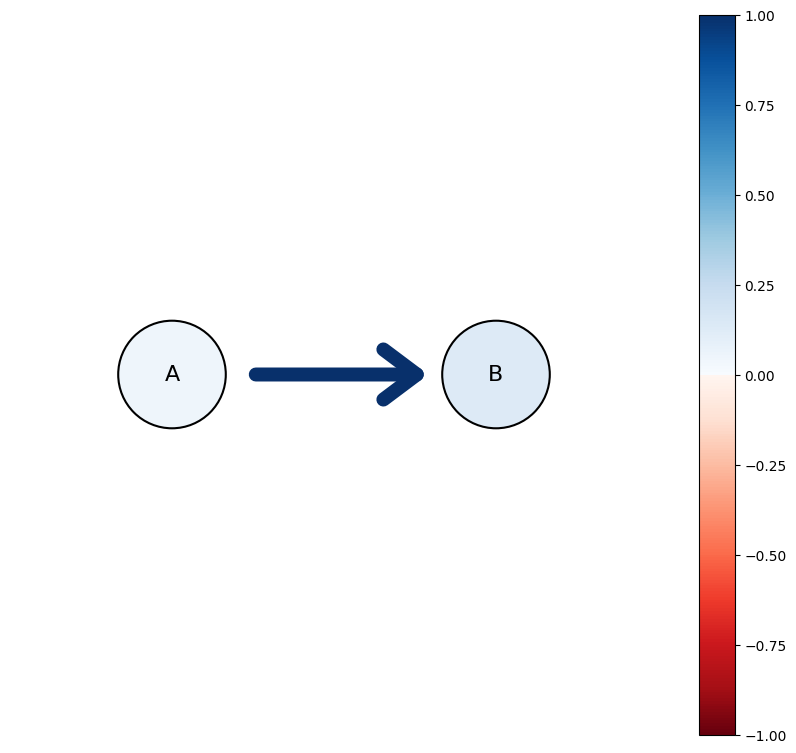

In [75]:
#A->B
path_to_sim = "/home/mzo5929/Keerthana/grnInference/simulation_data/median_parameter_simulations/simulations/df_row_0_1_14072025_175926_ncells_10000_A_to_B_9c7f0cd0.csv"
gene_gene_corr_matrix_t1, twin_correlation_matrix_t1, twin_correlation_matrix_t2, random_correlation_matrix_t1, correlation_matrix_directional, fig, ax, sm = create_network_plot(path_to_sim)

data['A_to_B'] = {
    'directional': correlation_matrix_directional,
    'gene_gene': gene_gene_corr_matrix_t1,
    'random_t1': random_correlation_matrix_t1,
    'twin_t1': twin_correlation_matrix_t1,
    'twin_t2': twin_correlation_matrix_t2
}
fig.savefig(f"{output_folder}/colour_bar.svg", format='svg')
fig.savefig(f"{output_folder}/colour_bar.png", format='png')

['gene_1', 'gene_2']
gene_gene_corr_matrix_t1
         gene_1   gene_2
gene_1  1.00000 -0.01167
gene_2 -0.01167  1.00000
twin_correlation_matrix_t1
          gene_1    gene_2
gene_1  1.000000 -0.003205
gene_2 -0.003205  1.000000
twin_correlation_matrix_t2
          gene_1    gene_2
gene_1  1.000000  0.001674
gene_2  0.001674  1.000000
random_correlation_matrix_t1
          gene_1    gene_2
gene_1  1.000000 -0.003328
gene_2 -0.003328  1.000000
['gene_1', 'gene_2']


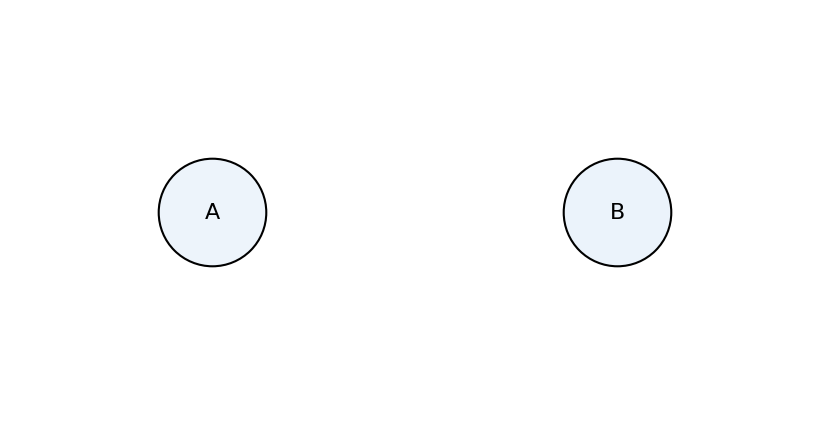

In [9]:
#No regulation
path_to_sim = "/home/mzo5929/Keerthana/grnInference/simulation_data/median_parameter_simulations/simulations/df_row_0_1_14072025_220943_ncells_10000_A_B_261640e4.csv"
gene_gene_corr_matrix_t1, twin_correlation_matrix_t1, twin_correlation_matrix_t2, random_correlation_matrix_t1, correlation_matrix_directional, fig, ax, sm = create_network_plot(path_to_sim)

data['A_B_median'] = {
    'directional': correlation_matrix_directional,
    'gene_gene': gene_gene_corr_matrix_t1,
    'random_t1': random_correlation_matrix_t1,
    'twin_t1': twin_correlation_matrix_t1,
    'twin_t2': twin_correlation_matrix_t2
}
# fig.savefig(f"{output_folder}/network_A_B_median.svg", format='svg')
# fig.savefig(f"{output_folder}/network_A_B_median.png", format='png')

['gene_1', 'gene_2']
gene_gene_corr_matrix_t1
          gene_1    gene_2
gene_1  1.000000  0.083216
gene_2  0.083216  1.000000
Interaction (gene_1, gene_2) = 0.08321632169170766
Interaction (gene_2, gene_1) = 0.08321632169170766
twin_correlation_matrix_t1
          gene_1    gene_2
gene_1  1.000000  0.009234
gene_2  0.009234  1.000000
twin_correlation_matrix_t2
          gene_1    gene_2
gene_1  1.000000  0.019257
gene_2  0.019257  1.000000
random_correlation_matrix_t1
          gene_1    gene_2
gene_1  1.000000  0.071804
gene_2  0.071804  1.000000
['gene_1', 'gene_2']


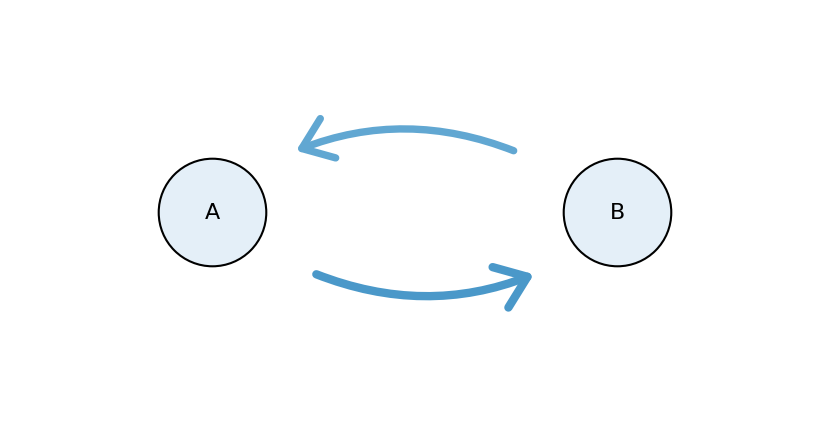

In [10]:
path_to_sim = "/home/mzo5929/Keerthana/grnInference/simulation_data/median_parameter_simulations/simulations/df_row_0_1_14072025_224456_ncells_10000_A_and_B_9f4b14e4.csv"
gene_gene_corr_matrix_t1, twin_correlation_matrix_t1, twin_correlation_matrix_t2, random_correlation_matrix_t1, correlation_matrix_directional, fig, ax, sm = create_network_plot(path_to_sim)

data['A_and_B_median'] = {
    'directional': correlation_matrix_directional,
    'gene_gene': gene_gene_corr_matrix_t1,
    'random_t1': random_correlation_matrix_t1,
    'twin_t1': twin_correlation_matrix_t1,
    'twin_t2': twin_correlation_matrix_t2
}
# fig.savefig(f"{output_folder}/network_A_and_B_median.svg", format='svg')
# fig.savefig(f"{output_folder}/network_A_and_B_median.png", format='png')

['gene_1', 'gene_2']
gene_gene_corr_matrix_t1
          gene_1    gene_2
gene_1  1.000000 -0.029189
gene_2 -0.029189  1.000000
twin_correlation_matrix_t1
          gene_1    gene_2
gene_1  1.000000 -0.004873
gene_2 -0.004873  1.000000
twin_correlation_matrix_t2
          gene_1    gene_2
gene_1  1.000000 -0.017361
gene_2 -0.017361  1.000000
random_correlation_matrix_t1
          gene_1    gene_2
gene_1  1.000000 -0.033712
gene_2 -0.033712  1.000000
['gene_1', 'gene_2']


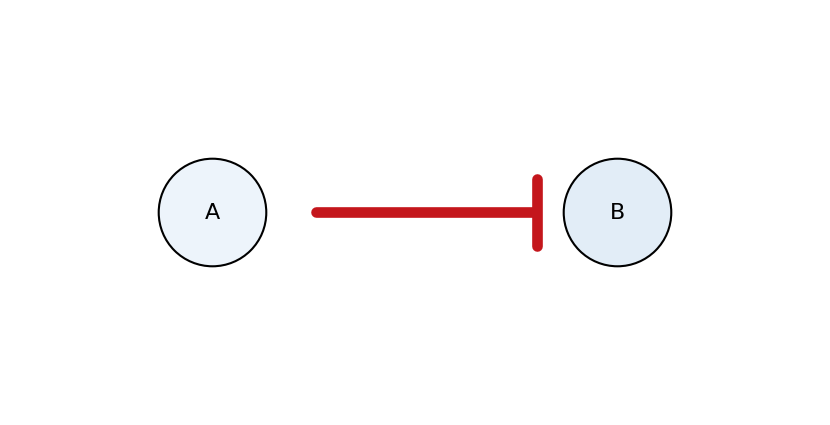

In [11]:
#Repression
path_to_sim = "/home/mzo5929/Keerthana/grnInference/simulation_data/median_parameter_simulations/simulations/df_row_6_7_14072025_190938_ncells_10000_A_rep_B_68dd1f7d.csv"
gene_gene_corr_matrix_t1, twin_correlation_matrix_t1, twin_correlation_matrix_t2, random_correlation_matrix_t1, correlation_matrix_directional, fig, ax, sm = create_network_plot(path_to_sim)

data['A_rep_B'] = {
    'directional': correlation_matrix_directional,
    'gene_gene': gene_gene_corr_matrix_t1,
    'random_t1': random_correlation_matrix_t1,
    'twin_t1': twin_correlation_matrix_t1,
    'twin_t2': twin_correlation_matrix_t2
}
fig.savefig(f"{output_folder}/network_A_rep_B_median.svg", format='svg')
fig.savefig(f"{output_folder}/network_A_rep_B_median.png", format='png')

['gene_1', 'gene_2', 'gene_3']
gene_gene_corr_matrix_t1
          gene_1    gene_2    gene_3
gene_1  1.000000  0.051083 -0.003176
gene_2  0.051083  1.000000  0.057916
gene_3 -0.003176  0.057916  1.000000
Interaction (gene_1, gene_2) = 0.05108327691259859
Interaction (gene_2, gene_1) = 0.051083276912598584
Interaction (gene_2, gene_3) = 0.05791579754560214
Interaction (gene_3, gene_2) = 0.05791579754560213
twin_correlation_matrix_t1
          gene_1    gene_2    gene_3
gene_1  1.000000  0.004852 -0.008402
gene_2  0.004852  1.000000  0.009631
gene_3 -0.008402  0.009631  1.000000
twin_correlation_matrix_t2
          gene_1    gene_2    gene_3
gene_1  1.000000  0.009349 -0.009018
gene_2  0.009349  1.000000  0.019613
gene_3 -0.009018  0.019613  1.000000
random_correlation_matrix_t1
          gene_1   gene_2    gene_3
gene_1  1.000000  0.04628  0.001037
gene_2  0.046280  1.00000  0.057890
gene_3  0.001037  0.05789  1.000000
['gene_1', 'gene_2', 'gene_3']


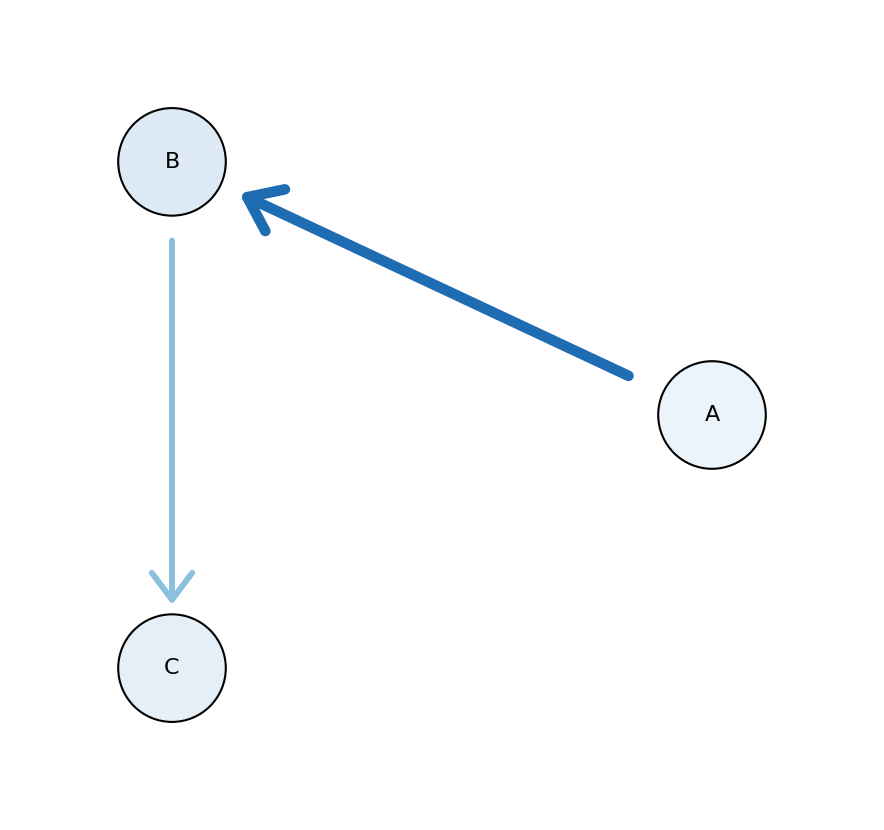

In [12]:
#Cascade
path_to_sim = "/home/mzo5929/Keerthana/grnInference/simulation_data/median_parameter_simulations/simulations/df_row_10_11_12_14072025_233548_ncells_10000_A_to_B_to_C_73acd23c.csv"
gene_gene_corr_matrix_t1, twin_correlation_matrix_t1, twin_correlation_matrix_t2, random_correlation_matrix_t1, correlation_matrix_directional, fig, ax, sm = create_network_plot(path_to_sim)

data['A_to_B_to_C'] = {
    'directional': correlation_matrix_directional,
    'gene_gene': gene_gene_corr_matrix_t1,
    'random_t1': random_correlation_matrix_t1,
    'twin_t1': twin_correlation_matrix_t1,
    'twin_t2': twin_correlation_matrix_t2
}
fig.savefig(f"{output_folder}/network_A_to_B_to_C_median.svg", format='svg')
fig.savefig(f"{output_folder}/network_A_to_B_to_C_median.png", format='png')

['gene_1', 'gene_2', 'gene_3']
gene_gene_corr_matrix_t1
          gene_1    gene_2    gene_3
gene_1  1.000000  0.050904  0.033628
gene_2  0.050904  1.000000  0.109547
gene_3  0.033628  0.109547  1.000000
Interaction (gene_1, gene_2) = 0.05090413550818718
Interaction (gene_2, gene_1) = 0.05090413550818718
Interaction (gene_2, gene_3) = 0.10954723255941126
Interaction (gene_3, gene_2) = 0.10954723255941126
twin_correlation_matrix_t1
          gene_1    gene_2    gene_3
gene_1  1.000000  0.021271 -0.022719
gene_2  0.021271  1.000000  0.001822
gene_3 -0.022719  0.001822  1.000000
twin_correlation_matrix_t2
          gene_1    gene_2    gene_3
gene_1  1.000000  0.036137  0.027683
gene_2  0.036137  1.000000  0.018285
gene_3  0.027683  0.018285  1.000000
random_correlation_matrix_t1
          gene_1    gene_2    gene_3
gene_1  1.000000  0.052096  0.032780
gene_2  0.052096  1.000000  0.115069
gene_3  0.032780  0.115069  1.000000
Two states for gene_2 and gene_3
Two states and regulation for ge

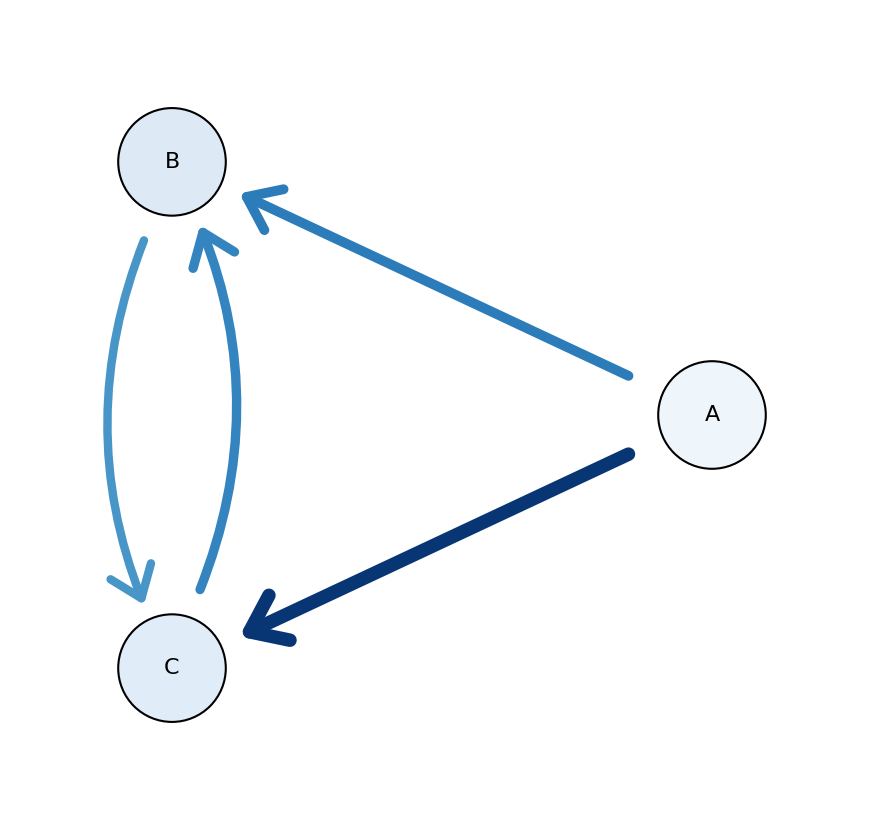

In [13]:
#Fan out
path_to_sim = "/home/mzo5929/Keerthana/grnInference/simulation_data/median_parameter_simulations/simulations/df_row_10_11_12_15072025_002815_ncells_10000_A_to_B_A_to_C_172ed241.csv"
gene_gene_corr_matrix_t1, twin_correlation_matrix_t1, twin_correlation_matrix_t2, random_correlation_matrix_t1, correlation_matrix_directional, fig, ax, sm = create_network_plot(path_to_sim)

data['A_to_B_A_to_C'] = {
    'directional': correlation_matrix_directional,
    'gene_gene': gene_gene_corr_matrix_t1,
    'random_t1': random_correlation_matrix_t1,
    'twin_t1': twin_correlation_matrix_t1,
    'twin_t2': twin_correlation_matrix_t2
}
# fig.savefig(f"{output_folder}/network_A_to_B_A_to_C_median.svg", format='svg')
# fig.savefig(f"{output_folder}/network_A_to_B_A_to_C_median.png", format='png')

['gene_1', 'gene_2']
gene_gene_corr_matrix_t1
          gene_1    gene_2
gene_1  1.000000 -0.288323
gene_2 -0.288323  1.000000
Interaction (gene_1, gene_2) = -0.2883227085307616
Interaction (gene_2, gene_1) = -0.2883227085307616
twin_correlation_matrix_t1
          gene_1    gene_2
gene_1  1.000000 -0.012906
gene_2 -0.012906  1.000000
twin_correlation_matrix_t2
          gene_1    gene_2
gene_1  1.000000 -0.011747
gene_2 -0.011747  1.000000
random_correlation_matrix_t1
          gene_1    gene_2
gene_1  1.000000 -0.269339
gene_2 -0.269339  1.000000
['gene_1', 'gene_2']


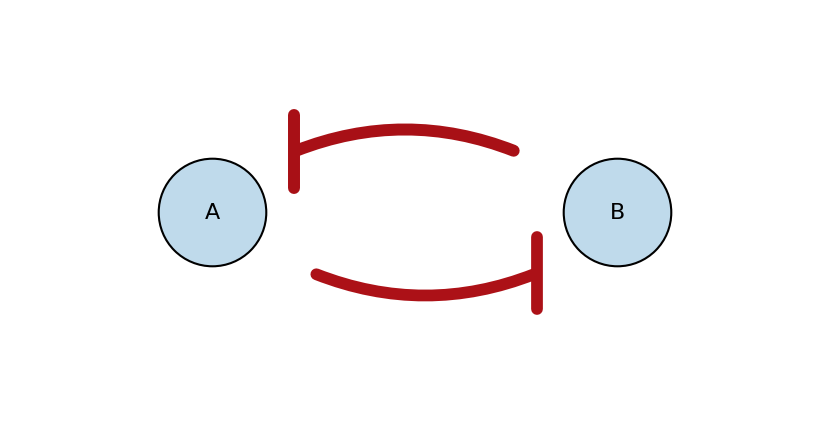

In [14]:
#Toggle switch
path_to_sim = "/home/mzo5929/Keerthana/grnInference/simulation_data/median_parameter_simulations/simulations/df_row_19_20_15072025_130426_ncells_10000_A_rep_B_B_rep_A_1d427973.csv"
gene_gene_corr_matrix_t1, twin_correlation_matrix_t1, twin_correlation_matrix_t2, random_correlation_matrix_t1, correlation_matrix_directional, fig, ax, sm = create_network_plot(path_to_sim)

data['A_rep_B_B_rep_A'] = {
    'directional': correlation_matrix_directional,
    'gene_gene': gene_gene_corr_matrix_t1,
    'random_t1': random_correlation_matrix_t1,
    'twin_t1': twin_correlation_matrix_t1,
    'twin_t2': twin_correlation_matrix_t2
}
# fig.savefig(f"{output_folder}/network_A_rep_B_B_rep_A_median.svg", format='svg')
# fig.savefig(f"{output_folder}/network_A_rep_B_B_rep_A_median.png", format='png')

['gene_1', 'gene_2']
gene_gene_corr_matrix_t1
          gene_1    gene_2
gene_1  1.000000  0.489191
gene_2  0.489191  1.000000
Interaction (gene_1, gene_2) = 0.48919058340091237
Interaction (gene_2, gene_1) = 0.4891905834009123
twin_correlation_matrix_t1
          gene_1    gene_2
gene_1  1.000000  0.014355
gene_2  0.014355  1.000000
twin_correlation_matrix_t2
          gene_1    gene_2
gene_1  1.000000  0.001377
gene_2  0.001377  1.000000
random_correlation_matrix_t1
          gene_1    gene_2
gene_1  1.000000  0.438568
gene_2  0.438568  1.000000
Two states for gene_1 and gene_2
Two states for gene_2 and gene_1
['gene_1', 'gene_2']


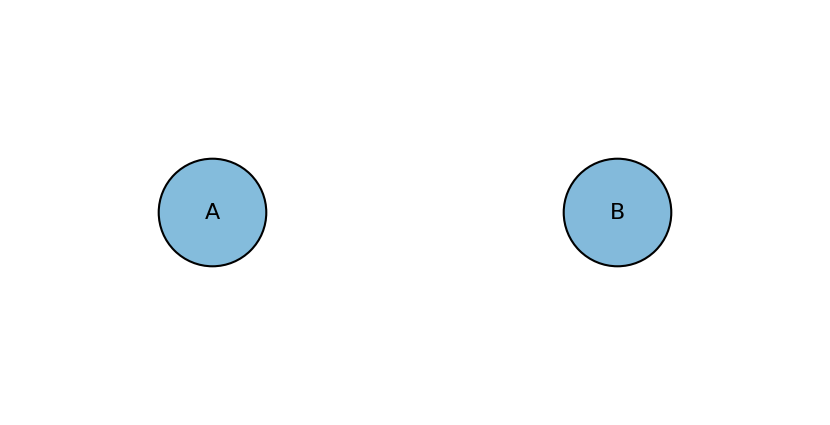

In [78]:
#2 states
df_state1 = pd.read_csv("/home/mzo5929/Keerthana/grnInference/simulation_data/median_parameter_simulations/simulations/df_rows_25_26_16072025_093653_ncells_10000_A_B_only_lower_k_on_03db176a.csv")
df_state2 = pd.read_csv("/home/mzo5929/Keerthana/grnInference/simulation_data/median_parameter_simulations/simulations/df_rows_27_28_16072025_100413_ncells_10000_A_B_only_higher_k_on_aa330570.csv")
df = pd.concat([df_state1, df_state2])
path_to_sim = "/home/mzo5929/Keerthana/grnInference/simulation_data/median_parameter_simulations/simulations/df_row_0_1_14072025_220943_ncells_10000_A_B_261640e4.csv"

gene_gene_corr_matrix_t1, twin_correlation_matrix_t1, twin_correlation_matrix_t2, random_correlation_matrix_t1, correlation_matrix_directional, fig, ax, sm = create_network_plot(path_to_sim, df = df)

fig.savefig(f"{output_folder}/network_A_B_2_states.svg", format='svg')
fig.savefig(f"{output_folder}/network_A_B_2_states.png", format='png')

data['A_B_2_states'] = {
    'directional': correlation_matrix_directional,
    'gene_gene': gene_gene_corr_matrix_t1,
    'random_t1': random_correlation_matrix_t1,
    'twin_t1': twin_correlation_matrix_t1,
    'twin_t2': twin_correlation_matrix_t2
}

['gene_1', 'gene_2']
gene_gene_corr_matrix_t1
         gene_1   gene_2
gene_1  1.00000  0.28186
gene_2  0.28186  1.00000
Interaction (gene_1, gene_2) = 0.2818597061383377
Interaction (gene_2, gene_1) = 0.2818597061383377
twin_correlation_matrix_t1
          gene_1    gene_2
gene_1  1.000000  0.006772
gene_2  0.006772  1.000000
twin_correlation_matrix_t2
          gene_1    gene_2
gene_1  1.000000  0.026687
gene_2  0.026687  1.000000
random_correlation_matrix_t1
          gene_1    gene_2
gene_1  1.000000  0.247596
gene_2  0.247596  1.000000
Two states for gene_1 and gene_2
Two states and regulation for gene_1 and gene_2
Two states for gene_2 and gene_1
Two states and regulation for gene_2 and gene_1
['gene_1', 'gene_2']


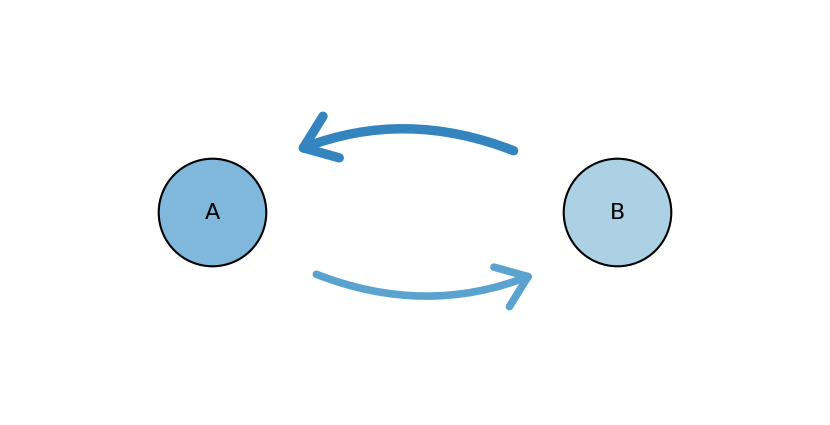

In [79]:
#2 states
df_state1 = pd.read_csv("/home/mzo5929/Keerthana/grnInference/simulation_data/median_parameter_simulations/simulations/df_rows_25_26_16072025_102511_ncells_10000_A_to_B_only_lower_k_on_f91be39b.csv")
df_state2 = pd.read_csv("/home/mzo5929/Keerthana/grnInference/simulation_data/median_parameter_simulations/simulations/df_rows_27_28_16072025_131623_ncells_10000_A_to_B_only_higher_k_on_e469aed7.csv")
df_state1 = df_state1[(df_state1['time_step'] == 5)| (df_state1['time_step'] == 10)]
df_state2 = df_state2[(df_state2['time_step'] == 5)| (df_state2['time_step'] == 10)]
df = pd.concat([df_state1, df_state2])
path_to_sim = "/home/mzo5929/Keerthana/grnInference/simulation_data/median_parameter_simulations/simulations/df_row_0_1_14072025_220943_ncells_10000_A_B_261640e4.csv"

gene_gene_corr_matrix_t1, twin_correlation_matrix_t1, twin_correlation_matrix_t2, random_correlation_matrix_t1, correlation_matrix_directional, fig, ax, sm = create_network_plot(path_to_sim, df = df)

fig.savefig(f"{output_folder}/network_A_to_B_2_states.svg", format='svg')
fig.savefig(f"{output_folder}/network_A_to_B_2_states.png", format='png')

data['A_to_B_2_states'] = {
    'directional': correlation_matrix_directional,
    'gene_gene': gene_gene_corr_matrix_t1,
    'random_t1': random_correlation_matrix_t1,
    'twin_t1': twin_correlation_matrix_t1,
    'twin_t2': twin_correlation_matrix_t2
}

In [72]:
from matplotlib.cm import ScalarMappable

# sm should be defined like this:
# sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # Ensures the colorbar knows it has data
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Correlation", fontsize=12)  # optional
plt.show()


## Plots for panel 2c


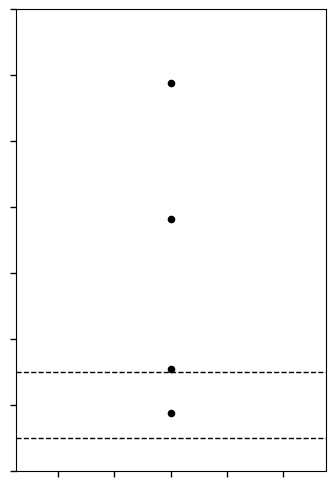

In [80]:
plt.figure(figsize=(4, 6))

plt.scatter(
    [0, 0, 0, 0],
    [
        data['A_to_B']['gene_gene'].iloc[0, 1],
        data['A_B_median']['gene_gene'].iloc[0, 1],
        data['A_B_2_states']['gene_gene'].iloc[0, 1],
        data['A_to_B_2_states']['gene_gene'].iloc[0, 1]
    ],
    color="black", s=20
)

plt.axhline(0.05, linestyle="--", color="black", linewidth=1)
plt.axhline(-0.05, linestyle="--", color="black", linewidth=1)
plt.yticks(np.arange(-0.05, 0.75, 0.1) - 0.05)
# ✅ Keep ticks, remove labels
plt.tick_params(
    axis='both',
    which='both',
    bottom=True, top=False, left=True, right=False,
    labelbottom=False, labelleft=False,  # Hides tick labels
    length=4, width=1
)

plt.box(True)
plt.savefig(f"{output_folder}/gene_gene_correlations_2c.svg", format="svg")
plt.savefig(f"{output_folder}/gene_gene_correlations_2c.png", format="png")
plt.show()

In [49]:
data['A_to_B_2_states']

{'directional':           gene_1    gene_2
 gene_1  0.240292  0.162773
 gene_2  0.116371  0.376655,
 'gene_gene':           gene_1    gene_2
 gene_1  1.000000  0.150302
 gene_2  0.150302  1.000000,
 'random_t1':          gene_1   gene_2
 gene_1  1.00000  0.14087
 gene_2  0.14087  1.00000,
 'twin_t1':           gene_1    gene_2
 gene_1  1.000000  0.027638
 gene_2  0.027638  1.000000,
 'twin_t2':           gene_1    gene_2
 gene_1  1.000000  0.029662
 gene_2  0.029662  1.000000}

In [43]:
data['A_to_B']['twin_t1'].iloc[0, 1]

0.02729436933482383

In [48]:
data['A_to_B_2_states']['random_t1'].iloc[0, 1]/data['A_to_B_2_states']['twin_t1'].iloc[0, 1]

5.096996852949365

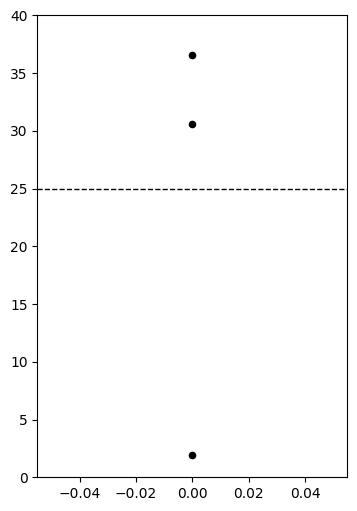

In [81]:
plt.figure(figsize=(4, 6))

plt.scatter(
    [0, 0,0],
    [
        data['A_to_B']['random_t1'].iloc[0, 1]/data['A_to_B']['twin_t1'].iloc[0, 1],
        # abs(data['A_B_median']['random_t1'].iloc[0, 1]/data['A_to_B']['twin_t1'].iloc[0, 1]),
        abs(data['A_B_2_states']['random_t1'].iloc[0, 1]/data['A_B_2_states']['twin_t1'].iloc[0, 1]),
        abs(data['A_to_B_2_states']['random_t1'].iloc[0, 1]/data['A_to_B_2_states']['twin_t1'].iloc[0, 1])
    ],
    color="black", s=20
)

plt.axhline(25, linestyle="--", color="black", linewidth=1)
# plt.axhline(-0.05, linestyle="--", color="black", linewidth=1)
plt.yticks(np.arange(0, 41,5))
# ✅ Keep ticks, remove labels
# plt.tick_params(
#     axis='both',
#     which='both',
#     bottom=False, top=False, left=True, right=False,
#     labelbottom=False, labelleft=False,  # Hides tick labels
#     length=4, width=1
# )

# plt.box(True)
# plt.savefig(f"{output_folder}/ratio_random_twin_correlations_2c.svg", format="svg")
# plt.savefig(f"{output_folder}/ratio_random_twin_correlations_2c.png", format="png")
plt.show()
# plt.yscale('log')


In [50]:
abs((data['A_B_2_states']['twin_t2'].iloc[0, 1] - data['A_B_2_states']['twin_t1'].iloc[0, 1])/data['A_B_2_states']['twin_t1'].iloc[0, 1])

0.9040508656739732

In [45]:
(data['A_B_2_states']['twin_t1'])

,gene_1,gene_2
gene_1,1.000000,0.014355
gene_2,0.014355,1.000000


([<matplotlib.axis.YTick at 0x152dfaa5c990>,
 [Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.5, '1.5'),
  Text(0, 2.0, '2.0'),
  Text(0, 2.5, '2.5'),
  Text(0, 3.0, '3.0')])

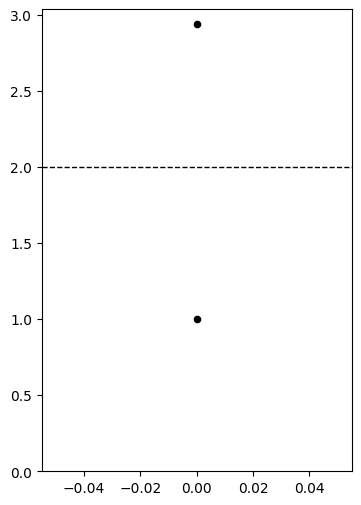

In [82]:
plt.figure(figsize=(4, 6))

plt.scatter(
    [0, 0],
    [
        # data['A_to_B']['random_t1'].iloc[0, 1]/data['A_to_B']['twin_t1'].iloc[0, 1],
        # abs(data['A_B_median']['random_t1'].iloc[0, 1]/data['A_to_B']['twin_t1'].iloc[0, 1]),
        abs((data['A_B_2_states']['twin_t2'].iloc[0, 1] - data['A_B_2_states']['twin_t1'].iloc[0, 1]/data['A_B_2_states']['twin_t1'].iloc[0, 1])),
        abs((data['A_to_B_2_states']['twin_t2'].iloc[0, 1] - data['A_to_B_2_states']['twin_t1'].iloc[0, 1])/data['A_to_B_2_states']['twin_t1'].iloc[0, 1])
    ],
    color="black", s=20
)

plt.axhline(2, linestyle="--", color="black", linewidth=1)
# plt.axhline(-0.05, linestyle="--", color="black", linewidth=1)
plt.yticks(np.arange(0, 3.5,0.5))
# ✅ Keep ticks, remove labels
# plt.tick_params(
#     axis='both',
#     which='both',
#     bottom=False, top=False, left=True, right=False,
#     labelbottom=False, labelleft=False,  # Hides tick labels
#     length=4, width=1
# )

# # plt.box(True)
# plt.savefig(f"{output_folder}/ratio_twin_times_correlations_2c.svg", format="svg")
# plt.savefig(f"{output_folder}/ratio_twin_times_correlations_2c.png", format="png")
# plt.show()
# plt.yscale('log')
